In [273]:
import pandas as pd
import os
import sys
import ast

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sys.path.append(os.path.abspath('..')) # need this to import metadata_functions
from preprocessing_data.metadata_functions import extract_subject_names, count_subjects


### Import data

In [66]:
# topic data
doc_topic_df = pd.read_csv("../data/lda_output/bill_topic_probs.csv", index_col=0)

doc_topic_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23
110-hr1752,0.147512,0.000014,0.013023,0.000013,0.068225,0.000013,0.000012,0.000012,0.000016,0.000016,...,0.000932,0.007295,0.136063,0.000011,0.000012,0.000014,0.014907,0.000018,0.011307,0.012896
110-hr1999,0.000194,0.000220,0.000224,0.000208,0.000192,0.000210,0.000192,0.000181,0.000250,0.146145,...,0.000304,0.000177,0.000227,0.000171,0.000191,0.000221,0.000278,0.000285,0.000194,0.000208
110-s1386,0.131609,0.000013,0.000013,0.000012,0.000011,0.000012,0.000011,0.000010,0.016786,0.040274,...,0.006233,0.000010,0.000013,0.000010,0.214463,0.000013,0.024016,0.000016,0.000485,0.000012
110-hr1227,0.003575,0.000008,0.365646,0.000922,0.000007,0.000008,0.000007,0.000007,0.102188,0.027100,...,0.114316,0.000006,0.000008,0.000006,0.000007,0.064243,0.179143,0.141270,0.000007,0.000008
110-hr1515,0.000536,0.000609,0.000619,0.124232,0.000531,0.000579,0.000531,0.000500,0.000692,0.000674,...,0.000838,0.000488,0.601947,0.000471,0.000527,0.000611,0.000767,0.000788,0.000537,0.000575


In [70]:
# topics with highest probability - going to consider this the topic assignment for analysis
best_topic_df = pd.DataFrame(index=doc_topic_df.index)
best_topic_df["best_topic"] = doc_topic_df.idxmax(axis=1)
best_topic_df["best_topic_prob"] = doc_topic_df.max(axis=1)

best_topic_df

,best_topic,best_topic_prob
110-hr1752,topic_10,0.507302
110-hr1999,topic_13,0.848890
110-s1386,topic_10,0.556343
110-hr1227,topic_2,0.365646
110-hr1515,topic_16,0.601947
...,...,...
119-hr889,topic_14,0.785245
119-s965,topic_8,0.479727
119-hr5387,topic_14,0.302884
119-hr4457,topic_3,0.964953


In [118]:
# metadata

metadata_files = os.listdir("../data/processed_metadata")
file_categories = ["cosponsors","actions","summaries","sponsors","subjects","committees","relatedBills","titles"]

# read all metadata into nested dictionaries by category and session
all_metadata_dict = {}

for category in file_categories:

    files = [file for file in metadata_files if f"_{category}_" in file]
    category_dict = {}

    for file in files:
        session = file[0:3]
        df = pd.read_csv("../data/processed_metadata/"+file)
        category_dict[session] = df

    all_metadata_dict[category] = category_dict

all_metadata_dict.keys() # these are all the keys

dict_keys(['cosponsors', 'actions', 'summaries', 'sponsors', 'subjects', 'committees', 'relatedBills', 'titles'])

In [126]:
# handling metadata files separately to avoid bugs in file name matching

files = [file for file in metadata_files if len(file)==16]
meta_dict = {}

for file in files:
    session = file[0:3]
    session = file[0:3]
    df = pd.read_csv("../data/processed_metadata/"+file)
    meta_dict[session] = df

all_metadata_dict["metadata"] = meta_dict

all_metadata_dict.keys() # metadata now in the overall dict

dict_keys(['cosponsors', 'actions', 'summaries', 'sponsors', 'subjects', 'committees', 'relatedBills', 'titles', 'metadata'])

In [130]:
# combine all the session dfs into one df per category

combined_metadata = {}

for category, session_dict in all_metadata_dict.items():

    combined_df = pd.concat(session_dict.values(),ignore_index=True)
    combined_metadata[category] = combined_df

combined_metadata.keys()

dict_keys(['cosponsors', 'actions', 'summaries', 'sponsors', 'subjects', 'committees', 'relatedBills', 'titles', 'metadata'])

### Subjects

In [233]:
subject_df = combined_metadata["subjects"]

subject_df.head()

,legislativeSubjects,policyArea.name,policyArea.updateDate,bill_id,extracted_subjects,subject_list,subject_names
0,[],Housing and Community Development,2022-02-03T19:18:42Z,117-hr6516,,,
1,[],Housing and Community Development,2022-02-16T19:45:20Z,117-hr6529,,,
2,[],Housing and Community Development,2022-01-28T20:32:46Z,117-hr6496,,,
3,"[{'name': 'Child safety and welfare', 'updateD...",Housing and Community Development,2022-01-26T17:33:16Z,117-hr6453,"Child safety and welfare, Drug, alcohol, tobac...","Child safety and welfare, Drug, alcohol, tobac...","Child safety and welfare, Drug, alcohol, tobac..."
4,[],Housing and Community Development,2022-01-26T17:33:15Z,117-hr6426,,,


In [234]:
subject_df["subject_names"] = subject_df["legislativeSubjects"].apply(extract_subject_names)

In [235]:
subject_df["bill_id"] = subject_df["bill_id"].str.lower() # format bill_id for merging
best_topic_df_subjects = best_topic_df.merge(right=subject_df, left_index=True, right_on="bill_id") # merge with topics

best_topic_df_subjects.head()

,best_topic,best_topic_prob,legislativeSubjects,policyArea.name,policyArea.updateDate,bill_id,extracted_subjects,subject_list,subject_names
1387,topic_10,0.507302,"[{'name': 'Apartment houses', 'updateDate': '2...",Housing and Community Development,2017-12-14T18:17:13Z,110-hr1752,"Apartment houses, Auditing, Condominium (Housi...","Apartment houses, Auditing, Condominium (Housi...","Apartment houses, Auditing, Condominium (Housi..."
1384,topic_13,0.848890,"[{'name': 'Affordable housing', 'updateDate': ...",Housing and Community Development,2017-12-14T18:23:55Z,110-hr1999,"Affordable housing, Community development, Com...","Affordable housing, Community development, Com...","Affordable housing, Community development, Com..."
1364,topic_10,0.556343,"[{'name': 'Counseling', 'updateDate': '2017-12...",Housing and Community Development,2017-12-14T23:15:43Z,110-s1386,"Counseling, Data banks, Economics and Public F...","Counseling, Data banks, Economics and Public F...","Counseling, Data banks, Economics and Public F..."
1398,topic_2,0.365646,"[{'name': 'Alabama', 'updateDate': '2017-12-14...",Housing and Community Development,2017-12-14T17:20:44Z,110-hr1227,"Alabama, Alien labor, Authorization, Block gra...","Alabama, Alien labor, Authorization, Block gra...","Alabama, Alien labor, Authorization, Block gra..."
1386,topic_16,0.601947,"[{'name': 'Block grants', 'updateDate': '2017-...",Housing and Community Development,2017-12-14T17:34:10Z,110-hr1515,"Block grants, Community development, Economics...","Block grants, Community development, Economics...","Block grants, Community development, Economics..."


In [236]:
best_topic_df_subjects['subject_list'] = best_topic_df_subjects['subject_names'].apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])

# Explode so each subject gets its own row
exploded_best_topic_df_subjects = best_topic_df_subjects.explode('subject_list')

subject_topic_crosstab = pd.crosstab(
    exploded_best_topic_df_subjects['subject_list'], 
    exploded_best_topic_df_subjects['best_topic']
)

subject_topic_crosstab


best_topic,topic_0,topic_1,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,...,topic_21,topic_22,topic_23,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
subject_list,,,,,,,,,,,,,,,,,,,,,
Academic performance,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Academic performance and assessments,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Access to health care,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Accidents,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Accounting and auditing,8,0,9,0,3,0,0,3,1,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
trees,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
volunteer service,0,0,2,5,0,4,0,0,1,0,...,2,0,8,3,0,0,2,0,4,0
voting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,3,0,0,0,0


In [237]:
# Get top 15 subjects for each topic as a dictionary
top_per_topic = {}

for topic in subject_topic_crosstab.columns:
    top_15 = subject_topic_crosstab[topic].nlargest(15)
    top_per_topic[topic] = top_15[top_15 > 0]  # Only show non-zero


In [238]:
top_per_topic.keys()

dict_keys(['topic_0', 'topic_1', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_2', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9'])

In [239]:
for key in top_per_topic.keys():

    print(top_per_topic[key])

subject_list
Housing finance and home ownership               26
Congressional oversight                          15
Administrative law and regulatory procedures     14
Department of Housing and Urban Development      10
Accounting and auditing                           8
Government studies and investigations             8
Housing industry and standards                    8
Fraud offenses and financial crimes               7
Government information and archives               7
Banking and financial institutions regulation     6
Government trust funds                            6
State and local government operations             6
Executive agency funding and structure            5
Housing and community development funding         5
Administrative remedies                           4
Name: topic_0, dtype: int64
subject_list
Housing and community development funding      18
State and local government operations          14
Housing finance and home ownership             11
Government infor

#### Subjects over time

In [247]:
metadata_df = combined_metadata["metadata"]
metadata_df["bill_id"] = metadata_df["bill_id"].str.lower() # format bill_id for merging
topic_subject_metadata = best_topic_df_subjects.merge(right=metadata_df, left_on="bill_id", right_on="bill_id") # merge with topics

In [257]:
time_anal_df = topic_subject_metadata[["best_topic","extracted_subjects","subject_list","metadata.introducedDate"]]

time_anal_df["introducedDate"] = pd.to_datetime(time_anal_df["metadata.introducedDate"])
time_anal_df["year"] = time_anal_df["introducedDate"].dt.year
time_anal_df["month"] = time_anal_df["introducedDate"].dt.to_period("M")

time_anal_df

/var/folders/5c/d2k1t24s5zl213152tpfh6nh0000gn/T/ipykernel_79955/1583648445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_anal_df["introducedDate"] = pd.to_datetime(time_anal_df["metadata.introducedDate"])
/var/folders/5c/d2k1t24s5zl213152tpfh6nh0000gn/T/ipykernel_79955/1583648445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_anal_df["year"] = time_anal_df["introducedDate"].dt.year
/var/folders/5c/d2k1t24s5zl213152tpfh6nh0000gn/T/ipykernel_79955/1583648445.py:5: SettingWithCopyWarning:

,best_topic,extracted_subjects,subject_list,metadata.introducedDate,introducedDate,year,month
0,topic_10,"Apartment houses, Auditing, Condominium (Housi...","[Apartment houses, Auditing, Condominium (Hous...",2007-03-29,2007-03-29,2007,2007-03
1,topic_13,"Affordable housing, Community development, Com...","[Affordable housing, Community development, Co...",2007-04-23,2007-04-23,2007,2007-04
2,topic_10,"Counseling, Data banks, Economics and Public F...","[Counseling, Data banks, Economics and Public ...",2007-05-14,2007-05-14,2007,2007-05
3,topic_2,"Alabama, Alien labor, Authorization, Block gra...","[Alabama, Alien labor, Authorization, Block gr...",2007-02-28,2007-02-28,2007,2007-02
4,topic_16,"Block grants, Community development, Economics...","[Block grants, Community development, Economic...",2007-03-14,2007-03-14,2007,2007-03
...,...,...,...,...,...,...,...
1642,topic_14,"Employment and training programs, Housing and ...","[Employment and training programs, Housing and...",2025-01-31,2025-01-31,2025,2025-01
1643,topic_8,,[],2025-03-11,2025-03-11,2025,2025-03
1644,topic_14,,[],2025-09-16,2025-09-16,2025,2025-09
1645,topic_3,,[],2025-07-16,2025-07-16,2025,2025-07


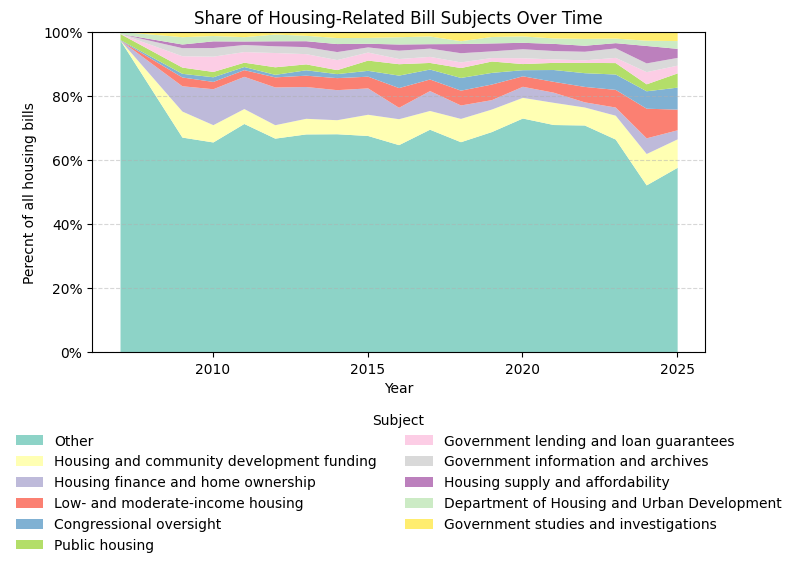

In [284]:
N = 10  # Number of top subjects to show individually

#  EXPLODE SUBJECT LIST 
subjects_exploded = time_anal_df.explode("subject_list")

#  COUNT BILLS BY YEAR × SUBJECT 
subject_trends = (
    subjects_exploded
    .groupby(["year", "subject_list"])
    .size()
    .reset_index(name="count")
)

#  COMPUTE TOTAL BILLS PER YEAR 
year_totals = subject_trends.groupby("year")["count"].sum().reset_index(name="year_total")

#  CALCULATE PERCENTAGE OF BILLS 
subject_trends = subject_trends.merge(year_totals, on="year")
subject_trends["percent"] = subject_trends["count"] / subject_trends["year_total"] * 100

#  IDENTIFY TOP N SUBJECTS 
top_subjects = subject_trends.groupby("subject_list")["count"].sum().nlargest(N).index

#  GROUP REMAINING SUBJECTS AS "Other" 
subject_trends["subject_grouped"] = subject_trends["subject_list"].where(
    subject_trends["subject_list"].isin(top_subjects), "Other"
)

#  AGGREGATE PERCENTAGES AFTER GROUPING 
subject_percent_trends = (
    subject_trends
    .groupby(["year", "subject_grouped"])["percent"]
    .sum()
    .reset_index()
)

#  PIVOT FOR STACKED AREA PLOT 
plot_data = subject_percent_trends.pivot(index="year", columns="subject_grouped", values="percent").fillna(0)

#  ORDER STACKED AREAS: largest average percent at bottom 
avg_percent = plot_data.mean().sort_values(ascending=False)
plot_data = plot_data[avg_percent.index]  # largest first

#  PLOT STACKED AREA CHART 
fig, ax = plt.subplots(figsize=(8, 6))
plot_data.plot(
    kind='area',
    stacked=True,
    ax=ax,
    colormap='Set3',
    linewidth=0
)

#  CUSTOMIZE AXES 
ax.set_xticks([2010, 2015, 2020, 2025])  # only these years
ax.set_xlabel("Year")  # remove x-axis label
ax.set_ylabel("Perecnt of all housing bills")  # remove y-axis label
ax.yaxis.set_major_formatter(mtick.PercentFormatter())  # percent on y-axis
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_title("Share of Housing-Related Bill Subjects Over Time")

#  LEGEND BELOW THE PLOT, HORIZONTAL 
ax.legend(
    title="Subject",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,  # number of columns for legend
    frameon=False
)

plt.tight_layout()
plt.savefig("../figures/subjects_over_time.png")
plt.show()


In [291]:
topic_trends

,year,best_topic,count
0,2007,topic_0,3
1,2007,topic_1,2
2,2007,topic_10,6
3,2007,topic_13,4
4,2007,topic_14,6
...,...,...,...
344,2025,topic_5,2
345,2025,topic_6,1
346,2025,topic_7,2
347,2025,topic_8,5


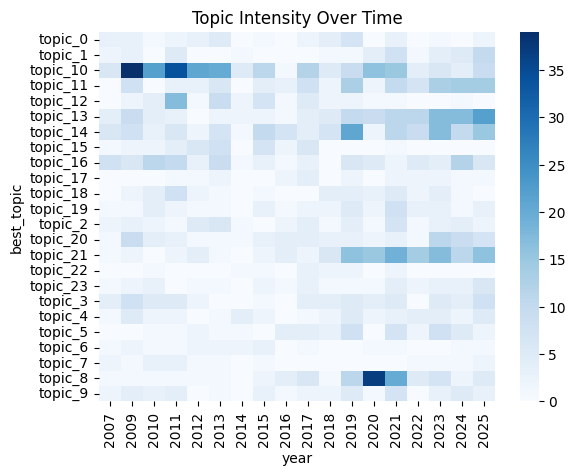

In [298]:
import seaborn as sns

heatmap_data = topic_trends.pivot(
    index="best_topic",
    columns="year",
    values="count"
).fillna(0)

sns.heatmap(heatmap_data, cmap="Blues")
plt.title("Topic Intensity Over Time")
plt.show()

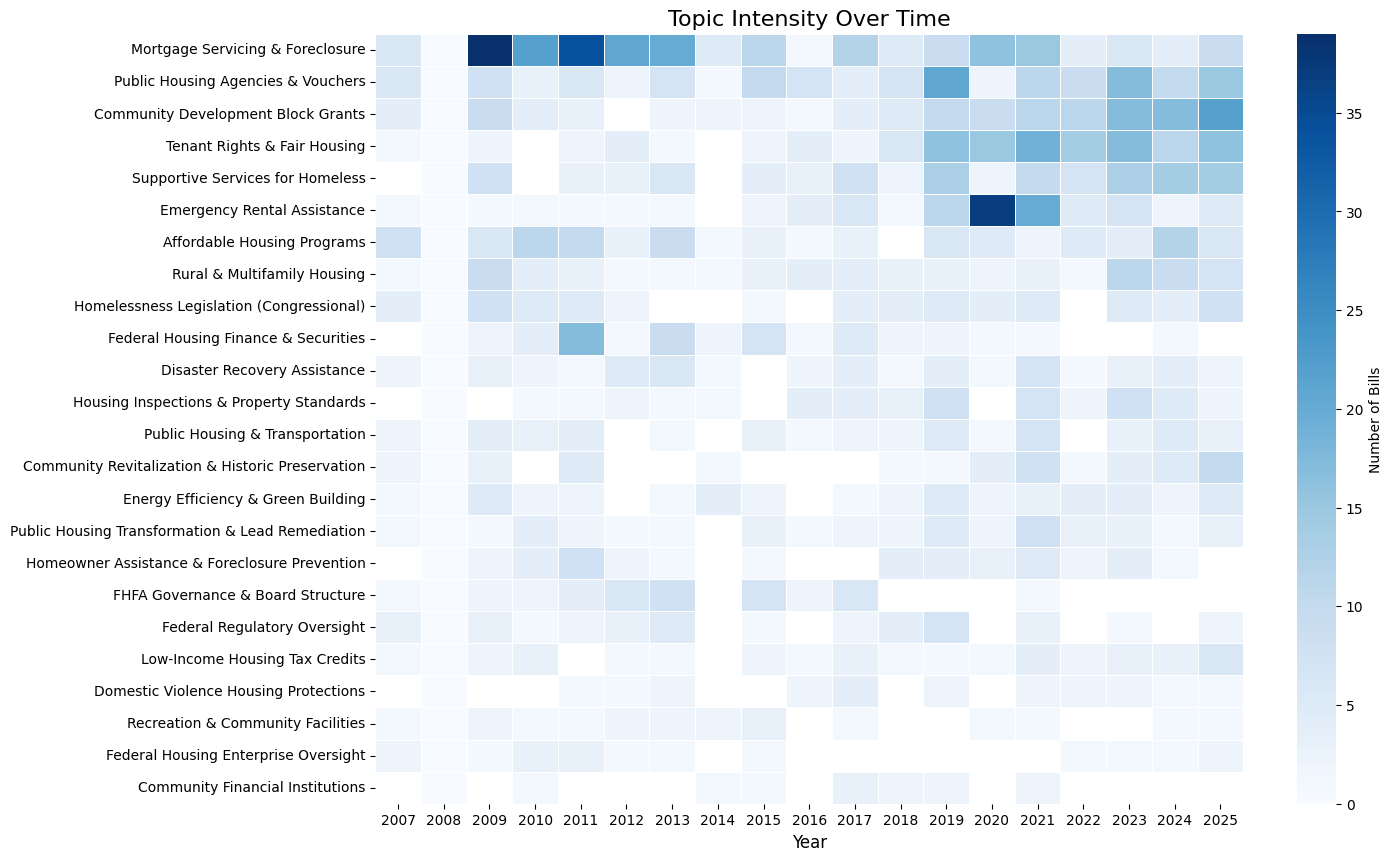

In [304]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: topic_trends DataFrame has columns ['year', 'best_topic', 'count']
# Make sure you have a mapping of topic numbers to names
topic_names = {
    'topic_0': "Federal Regulatory Oversight",
    'topic_1': "Community Revitalization & Historic Preservation",
    'topic_2': "Disaster Recovery Assistance",
    'topic_3': "Homelessness Legislation (Congressional)",
    'topic_4': "Energy Efficiency & Green Building",
    'topic_5': "Housing Inspections & Property Standards",
    'topic_6': "Recreation & Community Facilities",
    'topic_7': "Federal Housing Enterprise Oversight",
    'topic_8': "Emergency Rental Assistance",
    'topic_9': "Public Housing & Transportation",
    'topic_10': "Mortgage Servicing & Foreclosure",
    'topic_11': "Supportive Services for Homeless",
    'topic_12': "Federal Housing Finance & Securities",
    'topic_13': "Community Development Block Grants",
    'topic_14': "Public Housing Agencies & Vouchers",
    'topic_15': "FHFA Governance & Board Structure",
    'topic_16': "Affordable Housing Programs",
    'topic_17': "Domestic Violence Housing Protections",
    'topic_18': "Homeowner Assistance & Foreclosure Prevention",
    'topic_19': "Public Housing Transformation & Lead Remediation",
    'topic_20': "Rural & Multifamily Housing",
    'topic_21': "Tenant Rights & Fair Housing",
    'topic_22': "Community Financial Institutions",
    'topic_23': "Low-Income Housing Tax Credits"
}

# Pivot the data
all_years = range(topic_trends['year'].min(), topic_trends['year'].max() + 1)
all_topics = topic_trends['best_topic'].unique()

heatmap_data = topic_trends.pivot(
    index='best_topic',
    columns='year',
    values='count'
).reindex(index=all_topics, columns=all_years, fill_value=0)

# Sort topics by total counts (largest at top)
topic_totals = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.loc[topic_totals.sort_values(ascending=False).index]

# Replace topic numbers with descriptive names
heatmap_data.index = heatmap_data.index.map(topic_names)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    heatmap_data,
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Number of Bills'}
)
plt.title("Topic Intensity Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("")  # Y-axis label not necessary if topic names are clear

plt.savefig("../figures/topic_heatmap.png")
plt.show(

)


### Sponsor Party

In [190]:
metadata_df = combined_metadata["metadata"]

In [ ]:
metadata_df['party'] = metadata_df['metadata.sponsors'].apply(lambda x: ast.literal_eval(x)[0]['party'] if x and x != '[]' else None) # extract the sponsoring party


In [206]:
metadata_df["bill_id"] = metadata_df["bill_id"].str.lower() # format bill_id for merging
best_topic_df_metadata = best_topic_df.merge(right=metadata_df, left_index=True, right_on="bill_id") # merge with topics


In [306]:
party_topic_crosstab = pd.crosstab(
    best_topic_df_metadata['party'], 
    best_topic_df_metadata['best_topic']
)

party_topic_crosstab

best_topic,topic_0,topic_1,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,...,topic_21,topic_22,topic_23,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
party,,,,,,,,,,,,,,,,,,,,,
D,19,32,193,86,14,117,80,12,75,16,...,116,7,20,49,32,33,18,12,89,39
I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3
R,18,13,46,24,41,16,66,27,20,4,...,16,5,15,15,13,16,1,5,15,4


In [307]:
for topic in party_topic_crosstab.columns:
    print(f"{topic}")
    # Iterate through rows (parties)
    for party, val in party_topic_crosstab[topic].items():
        print(f"{party}: {val}")
    print()  # Blank line between topics

topic_0
D: 19
I: 0
R: 18

topic_1
D: 32
I: 0
R: 13

topic_10
D: 193
I: 0
R: 46

topic_11
D: 86
I: 0
R: 24

topic_12
D: 14
I: 0
R: 41

topic_13
D: 117
I: 0
R: 16

topic_14
D: 80
I: 0
R: 66

topic_15
D: 12
I: 0
R: 27

topic_16
D: 75
I: 0
R: 20

topic_17
D: 16
I: 0
R: 4

topic_18
D: 34
I: 0
R: 7

topic_19
D: 39
I: 0
R: 4

topic_2
D: 29
I: 0
R: 20

topic_20
D: 48
I: 0
R: 22

topic_21
D: 116
I: 0
R: 16

topic_22
D: 7
I: 0
R: 5

topic_23
D: 20
I: 0
R: 15

topic_3
D: 49
I: 0
R: 15

topic_4
D: 32
I: 0
R: 13

topic_5
D: 33
I: 0
R: 16

topic_6
D: 18
I: 0
R: 1

topic_7
D: 12
I: 0
R: 5

topic_8
D: 89
I: 2
R: 15

topic_9
D: 39
I: 3
R: 4



### Bill Outcome

In [318]:
def categorize_bill_progress(action_text):
    """Categorize where bill died or if it passed"""
    
    action_lower = action_text.lower()
    
    # Enacted
    if 'became public law' in action_lower:
        return 'Enacted'
    
    # Passed one chamber
    if 'received in the senate' in action_lower or 'received in the house' in action_lower:
        return 'Other/Procedural'
    
    # Failed floor vote
    if 'failed by the yeas and nays' in action_lower:
        return 'Failed Floor Vote'
    
    # Advanced - placed on calendar
    if 'placed on' in action_lower and 'calendar' in action_lower:
        return 'Other/Procedural'
    
    # Advanced - ordered to be reported
    if 'ordered to be reported' in action_lower:
        return 'Other/Procedural'
    
    # Committee activity - hearings
    if 'hearings held' in action_lower or 'hearing held' in action_lower:
        return 'Other/Procedural'
    
    # Committee activity - forwarded
    if 'forwarded by subcommittee' in action_lower:
        return 'Other/Procedural'
    
    # Died in subcommittee
    if 'referred to the subcommittee' in action_lower:
        return 'Died in Subcommittee'
    
    # Died in committee (most common)
    if ('read twice and referred to the committee' in action_lower or 
        'referred to the house committee' in action_lower or
        'referred to the committee on' in action_lower):
        return 'Died in Committee'
    
    # Everything else
    return 'Other/Procedural'

# Apply to your dataframe
metadata_df['bill_progress'] = metadata_df["data.latestAction.text"].apply(categorize_bill_progress)

# See the distribution
metadata_df['bill_progress'].value_counts()

bill_progress
Died in Committee       1185
Died in Subcommittee     253
Other/Procedural         208
Enacted                    9
Failed Floor Vote          1
Name: count, dtype: int64

In [331]:
metadata_df["bill_id"] = metadata_df["bill_id"].str.lower() # format bill_id for merging
best_topic_df_metadata = best_topic_df.merge(how= "outer", right=metadata_df, left_index=True, right_on="bill_id") # merge with topics


In [332]:
best_topic_df_metadata["bill_progress"].value_counts()

bill_progress
Died in Committee       1185
Died in Subcommittee     253
Other/Procedural         208
Enacted                    9
Failed Floor Vote          1
Name: count, dtype: int64

In [339]:
best_topic_df_metadata[best_topic_df_metadata["best_topic"].isna()]

,best_topic,best_topic_prob,bill_id,text_url,text_file,data.congress,data.latestAction.actionDate,data.latestAction.text,data.number,data.originChamber,...,metadata.cboCostEstimates,metadata.committeeReports,metadata.constitutionalAuthorityStatementText,data.latestAction.actionTime,metadata.latestAction.actionTime,metadata.laws,metadata.notes,metadata.onBehalfOfSponsor,party,bill_progress
609.0,NaN,NaN,111-hr3553,https://www.congress.gov/111/plaws/publ269/PLA...,PLAW-111publ269.htm,111.0,2010-10-12,Became Public Law No: 111-269.,3553.0,House,...,[{'description': '<p>Cost estimate for the bil...,"[{'citation': 'S. Rept. 111-299', 'url': 'http...",NaN,NaN,NaN,"[{'number': '111-269', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
641.0,NaN,NaN,111-hr5872,https://www.congress.gov/111/plaws/publ228/PLA...,PLAW-111publ228.htm,111.0,2010-08-11,Became Public Law No: 111-228.,5872.0,House,...,[{'description': '<p>Pay-as-you-go table for t...,NaN,NaN,NaN,NaN,"[{'number': '111-228', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
640.0,NaN,NaN,111-hr5981,https://www.congress.gov/111/plaws/publ229/PLA...,PLAW-111publ229.htm,111.0,2010-08-11,Became Public Law No: 111-229.,5981.0,House,...,NaN,NaN,NaN,NaN,NaN,"[{'number': '111-229', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
543.0,NaN,NaN,111-s118,https://www.congress.gov/111/plaws/publ372/PLA...,PLAW-111publ372.htm,111.0,2011-01-04,Became Public Law No: 111-372.,118.0,Senate,...,[{'description': '<p>Cost estimate for the bil...,NaN,NaN,NaN,NaN,"[{'number': '111-372', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
542.0,NaN,NaN,111-s1481,https://www.congress.gov/111/plaws/publ374/PLA...,PLAW-111publ374.htm,111.0,2011-01-04,Became Public Law No: 111-374.,1481.0,Senate,...,[{'description': '<p>Cost estimate for the bil...,NaN,NaN,NaN,NaN,"[{'number': '111-374', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
623.0,NaN,NaN,111-s896,https://www.congress.gov/111/plaws/publ22/PLAW...,PLAW-111publ22.htm,111.0,2009-05-20,Became Public Law No: 111-22.,896.0,Senate,...,[{'description': '<p>Cost estimate for the bil...,NaN,NaN,NaN,NaN,"[{'number': '111-22', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
830.0,NaN,NaN,113-hr2167,https://www.congress.gov/113/plaws/publ29/PLAW...,PLAW-113publ29.htm,113.0,2013-08-09,Became Public Law No: 113-29.,2167.0,House,...,NaN,NaN,<pre>\nFrom the Congressional Record Online th...,NaN,NaN,"[{'number': '113-29', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
870.0,NaN,NaN,114-s2036,https://www.congress.gov/114/plaws/publ93/PLAW...,PLAW-114publ93.htm,114.0,2015-11-25,Became Public Law No: 114-93.,2036.0,Senate,...,NaN,NaN,NaN,NaN,NaN,"[{'number': '114-93', 'type': 'Public Law'}]",NaN,NaN,R,Enacted
404.0,NaN,NaN,116-s1749,https://www.congress.gov/116/plaws/publ33/PLAW...,PLAW-116publ33.htm,116.0,2019-07-25,Became Public Law No: 116-33.,1749.0,Senate,...,NaN,NaN,NaN,NaN,NaN,"[{'number': '116-33', 'type': 'Public Law'}]",NaN,NaN,D,Enacted


In [333]:
best_topic_df_metadata[best_topic_df_metadata["bill_progress"] == "Enacted"]

,best_topic,best_topic_prob,bill_id,text_url,text_file,data.congress,data.latestAction.actionDate,data.latestAction.text,data.number,data.originChamber,...,metadata.cboCostEstimates,metadata.committeeReports,metadata.constitutionalAuthorityStatementText,data.latestAction.actionTime,metadata.latestAction.actionTime,metadata.laws,metadata.notes,metadata.onBehalfOfSponsor,party,bill_progress
609.0,NaN,NaN,111-hr3553,https://www.congress.gov/111/plaws/publ269/PLA...,PLAW-111publ269.htm,111.0,2010-10-12,Became Public Law No: 111-269.,3553.0,House,...,[{'description': '<p>Cost estimate for the bil...,"[{'citation': 'S. Rept. 111-299', 'url': 'http...",NaN,NaN,NaN,"[{'number': '111-269', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
641.0,NaN,NaN,111-hr5872,https://www.congress.gov/111/plaws/publ228/PLA...,PLAW-111publ228.htm,111.0,2010-08-11,Became Public Law No: 111-228.,5872.0,House,...,[{'description': '<p>Pay-as-you-go table for t...,NaN,NaN,NaN,NaN,"[{'number': '111-228', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
640.0,NaN,NaN,111-hr5981,https://www.congress.gov/111/plaws/publ229/PLA...,PLAW-111publ229.htm,111.0,2010-08-11,Became Public Law No: 111-229.,5981.0,House,...,NaN,NaN,NaN,NaN,NaN,"[{'number': '111-229', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
543.0,NaN,NaN,111-s118,https://www.congress.gov/111/plaws/publ372/PLA...,PLAW-111publ372.htm,111.0,2011-01-04,Became Public Law No: 111-372.,118.0,Senate,...,[{'description': '<p>Cost estimate for the bil...,NaN,NaN,NaN,NaN,"[{'number': '111-372', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
542.0,NaN,NaN,111-s1481,https://www.congress.gov/111/plaws/publ374/PLA...,PLAW-111publ374.htm,111.0,2011-01-04,Became Public Law No: 111-374.,1481.0,Senate,...,[{'description': '<p>Cost estimate for the bil...,NaN,NaN,NaN,NaN,"[{'number': '111-374', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
623.0,NaN,NaN,111-s896,https://www.congress.gov/111/plaws/publ22/PLAW...,PLAW-111publ22.htm,111.0,2009-05-20,Became Public Law No: 111-22.,896.0,Senate,...,[{'description': '<p>Cost estimate for the bil...,NaN,NaN,NaN,NaN,"[{'number': '111-22', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
830.0,NaN,NaN,113-hr2167,https://www.congress.gov/113/plaws/publ29/PLAW...,PLAW-113publ29.htm,113.0,2013-08-09,Became Public Law No: 113-29.,2167.0,House,...,NaN,NaN,<pre>\nFrom the Congressional Record Online th...,NaN,NaN,"[{'number': '113-29', 'type': 'Public Law'}]",NaN,NaN,D,Enacted
870.0,NaN,NaN,114-s2036,https://www.congress.gov/114/plaws/publ93/PLAW...,PLAW-114publ93.htm,114.0,2015-11-25,Became Public Law No: 114-93.,2036.0,Senate,...,NaN,NaN,NaN,NaN,NaN,"[{'number': '114-93', 'type': 'Public Law'}]",NaN,NaN,R,Enacted
404.0,NaN,NaN,116-s1749,https://www.congress.gov/116/plaws/publ33/PLAW...,PLAW-116publ33.htm,116.0,2019-07-25,Became Public Law No: 116-33.,1749.0,Senate,...,NaN,NaN,NaN,NaN,NaN,"[{'number': '116-33', 'type': 'Public Law'}]",NaN,NaN,D,Enacted


In [337]:
best_topic_df.loc["116-s1749"]

KeyError: '116-s1749'

In [320]:
outcome_topic_crosstab = pd.crosstab(
    best_topic_df_metadata['bill_progress'], 
    best_topic_df_metadata['best_topic']
)

outcome_topic_crosstab

best_topic,topic_0,topic_1,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,...,topic_21,topic_22,topic_23,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
bill_progress,,,,,,,,,,,,,,,,,,,,,
Died in Committee,25,28,160,88,35,108,117,19,73,12,...,99,5,28,39,30,41,11,8,86,30
Died in Subcommittee,2,13,52,11,9,16,10,8,15,7,...,21,3,4,13,7,6,7,5,7,7
Failed Floor Vote,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Other/Procedural,10,4,27,11,11,9,19,12,7,1,...,12,4,3,12,8,2,1,4,13,9


In [317]:
for topic in outcome_topic_crosstab.columns:
    print(f"{topic}")
    # Iterate through rows (parties)
    for party, val in outcome_topic_crosstab[topic].items():
        print(f"{party}: {val}")
    print()  # Blank line between topics

topic_0
Died in Committee: 25
Died in Subcommittee: 2
Failed Floor Vote: 0
Other/Procedural: 10

topic_1
Died in Committee: 28
Died in Subcommittee: 13
Failed Floor Vote: 0
Other/Procedural: 4

topic_10
Died in Committee: 160
Died in Subcommittee: 52
Failed Floor Vote: 0
Other/Procedural: 27

topic_11
Died in Committee: 88
Died in Subcommittee: 11
Failed Floor Vote: 0
Other/Procedural: 11

topic_12
Died in Committee: 35
Died in Subcommittee: 9
Failed Floor Vote: 0
Other/Procedural: 11

topic_13
Died in Committee: 108
Died in Subcommittee: 16
Failed Floor Vote: 0
Other/Procedural: 9

topic_14
Died in Committee: 117
Died in Subcommittee: 10
Failed Floor Vote: 0
Other/Procedural: 19

topic_15
Died in Committee: 19
Died in Subcommittee: 8
Failed Floor Vote: 0
Other/Procedural: 12

topic_16
Died in Committee: 73
Died in Subcommittee: 15
Failed Floor Vote: 0
Other/Procedural: 7

topic_17
Died in Committee: 12
Died in Subcommittee: 7
Failed Floor Vote: 0
Other/Procedural: 1

topic_18
Died in 